In [1]:
import LC_model
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import scipy.stats as st
%matplotlib inline

In [2]:
def get_filenames(folder):
    
    filenames = [x for x in listdir(folder) if isfile(join(folder, x))\
                   if 'chains' in x and 'ipynb' not in x]
    heights = []
    widths = []
    
    for i in range(len(filenames)):
        
        f = filenames[i]
        _indexes = [x for x, char in enumerate(f) if char == '_']
        heights.append(float(f[_indexes[0]+2:_indexes[1]]))
        widths.append(float(f[_indexes[1]+2:-4]))
    
    return filenames, heights, widths

def get_foldernames(folder):
    
    foldernames = [x[0][len(folder):] for x in os.walk(folder)\
                   if 'data_h' in x[0] and 'pos' not in x[0]]
    
    heights = []
    widths = []
    
    for i in range(len(foldernames)):
        
        f = foldernames[i]
        _indexes = [x for x, char in enumerate(f) if char == '_']
        heights.append(float(f[_indexes[0]+2:_indexes[1]]))
        widths.append(float(f[_indexes[1]+2:_indexes[1]+7]))
    
    return foldernames, heights, widths

def get_chains_from_subfolder(master_folder,subfolder):
    
    currentpath = master_folder + subfolder
    chain_files = [currentpath+'/'+f for f in listdir(currentpath) if isfile(join(currentpath, f)) and '.dat' in f]
    CHAIN_LENGTH = 100000
    SAMPLES = 10000
    chains = np.empty((len(chain_files),SAMPLES,6))
    for i in range(len(chain_files)):
        chain_file = chain_files[i]
        chains[i,:,:] = np.loadtxt(chain_file, delimiter=",",skiprows=CHAIN_LENGTH-SAMPLES)
    return chains

def get_avg_iqr_from_chains(chains):
    
    means = np.empty(chains.shape[2])
    medians = np.empty(chains.shape[2])
    iqrs = np.empty(chains.shape[2])
    
    for i in range(means.size):
        means[i] = np.mean(chains[:,:,i].flatten())
        medians[i] = np.median(chains[:,:,i].flatten())
        iqrs[i] = st.iqr(chains[:,:,i].flatten())
        
    return means, medians, iqrs

In [3]:
"""master_folder = "../Data/"
filenames, heights, widths = get_filenames(master_folder)
chains = np.load(master_folder + filenames[0])"""

master_folder = "../Data2/"
foldernames, heights, widths = get_foldernames(master_folder)

In [6]:
"""means = np.empty((len(filenames),chains.shape[2]))
medians = np.empty((len(filenames),chains.shape[2]))
iqrs = np.empty((len(filenames),chains.shape[2]))

for i in range(len(filenames)):
    chains = np.load(master_folder + filenames[i])
    means[i,:], medians[i,:], iqrs[i,:] = get_avg_iqr_from_chains(chains)"""


medians = np.empty((len(foldernames),6))
iqrs = np.empty((len(foldernames),6))

for i in range(len(foldernames)):
    medians[i,:] = np.load(master_folder + foldernames[i]+"/param_med.npy")
    iqrs[i,:] = np.load(master_folder + foldernames[i]+"/param_iqr.npy")

[[8.74861082e-02 2.53111049e-02 6.61067520e-04 1.66083825e-04
  4.24533347e-01 7.41009462e-01]
 [7.18094775e-02 2.18254420e-02 5.70507125e-04 1.49622777e-04
  3.06976320e-01 3.73691783e-01]
 [2.01463943e-01 6.58396083e-02 1.20621900e-03 2.18773677e-03
  9.09689264e-02 5.71338366e-01]
 ...
 [1.67672157e-01 9.99692820e-02 1.15686191e-03 2.01000085e-03
  5.36301257e-01 9.35467585e-01]
 [2.42080279e-01 6.38910269e-02 1.51610435e-03 2.42596307e-04
  4.22657793e-01 7.46909539e-01]
 [8.73037746e-02 2.16461888e-02 3.95850527e-04 6.27074736e-04
  5.68262442e-01 8.53106816e-01]]


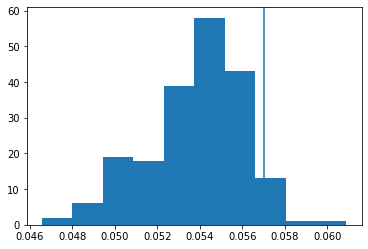

In [11]:
theta_0 = [141,0.057,1.5758, 233.6, 0.47,0.19] #true values
#normed_means = np.empty_like(means)
normed_medians = np.empty_like(medians)
normed_iqrs = np.empty_like(medians)

for i in range(medians.shape[0]):
    #normed_means[i,:] = np.abs(means[i,:] - theta_0)/theta_0
    normed_medians[i,:] = np.abs(medians[i,:] - theta_0)/theta_0
    normed_iqrs[i,:]  = iqrs[i,:] / medians[i,:]
    
print(normed_medians)
plt.hist(medians[:,1])
plt.axvline(x=theta_0[1])

In [ ]:
#print(means[:,2])

from mpl_toolkits.axes_grid1 import make_axes_locatable
w = np.array(list(set(widths)))
w = np.sort(w)
h = np.array(list(set(heights)))
h = np.sort(h)
for n in range(6):

    X , Y = np.meshgrid(w,h)
    Z = np.empty_like(X)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            index = np.where((widths == w[j]) & (heights == h[i]))[0]
            #print(normed_medians.shape,w[j],h[i],index,n)
            if(len(index)>0):
                Z[i,j] = 100*normed_medians[index,n]
            else:
                Z[i,j] = -1

    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,9),gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [4, 1]})
    fig.subplots_adjust(wspace=0,hspace=0)
    #ax[1,0].get_shared_x_axes().join(ax[1,0], ax[0,0])
    vmin = max(0,np.median(Z) - 2 * np.std(Z))
    vmax = np.median(Z) + 2 * np.std(Z)
    im1 = ax[1,0].pcolormesh(X, Y, Z, cmap='RdBu',shading='gouraud',vmin=vmin,vmax=vmax)
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im1, cax=cax, orientation='vertical')
    cb.set_label(label='% Bias in the Median', size=16)
    params = [r'$\frac{a}{R_s}$',r'$\frac{R_p}{R_s}$',r'$\theta$',r'$T$',r'$\gamma_1$',r'$\gamma_2$']
    ax[0,0].set_title(r"Parameter: "+params[n],size=20)
    ax[1,0].set_ylabel("Height of Perturbation [ppm]",size=16)
    ax[1,0].set_xlabel("Width of Perturbation [days]",size=16)
    ax[0,1].set_visible(False)
    ax[1,1].plot(np.median(Z,axis=0), np.arange(np.median(Z,axis=0).size), color='k')
    ax[0,0].plot(np.median(Z,axis=0), color = 'k')
    ax[0,0].set_ylabel("%")
    ax[1,1].set_xlabel("%")
    ax[1,1].set_yticklabels("")
    ax[1,0].set_yticks([200*x for x in range(1,10)])
    ax[1,0].set_xticks([0.01*x for x in range(1,5)])
    ax[0,0].grid()
    ax[1,1].grid()
    plt.savefig(params[n])
    plt.show()


In [ ]:
w = np.array(list(set(widths)))
w = np.sort(w)
h = np.array(list(set(heights)))
h = np.sort(h)
n = 5
X , Y = np.meshgrid(w,h)
Z = np.empty_like(X)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        index = np.where((widths == w[j]) & (heights == h[i]))[0]
        if(len(index)>0):
            Z[i,j] = 100*normed_iqrs[index,n]
        else:
            Z[i,j] = -1

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,9),gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [4, 1]})
fig.subplots_adjust(wspace=0,hspace=0)
#ax[1,0].get_shared_x_axes().join(ax[1,0], ax[0,0])
vmin = max(0,np.median(Z) - 2 * np.std(Z))
vmax = np.median(Z) + 2 * np.std(Z)
im1 = ax[1,0].pcolormesh(X, Y, Z, cmap='RdBu',shading='gouraud',vmin=vmin,vmax=vmax)
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im1, cax=cax, orientation='vertical')
cb.set_label(label='% IQR of Poterior', size=16)
params = [r'$\frac{a}{R_s}$',r'$\frac{R_p}{R_s}$','Inclination','Period',r'$\gamma_1$',r'$\gamma_2$']
ax[0,0].set_title(r"Parameter: "+params[n],size=20)
ax[1,0].set_ylabel("Height of Perturbation [ppm]",size=16)
ax[1,0].set_xlabel("Width of Perturbation [days]",size=16)
ax[0,1].set_visible(False)
ax[1,1].plot(np.median(Z,axis=0), np.arange(np.median(Z,axis=0).size), color='k')
ax[0,0].plot(np.median(Z,axis=0), color = 'k')
ax[0,0].set_ylabel("IQR %")
ax[1,1].set_xlabel("IQR %")
ax[1,1].set_yticklabels("")
ax[1,0].set_yticks([200*x for x in range(1,10)])
ax[1,0].set_xticks([0.01*x for x in range(1,5)])
ax[0,0].grid()
ax[1,1].grid()
plt.savefig(params[n]+'_iqr')
plt.show()
print(iqrs[:,0])

In [ ]:
import numpy as np
import os
from os import listdir
from os.path import isfile, join

CHAIN_LENGTH = 100000
SAMPLES_TO_EXTRACT = 10000

def get_foldernames(folder):
    
    foldernames = [x[0][len(folder):] for x in os.walk(folder)\
                   if 'data_h' in x[0] and 'ipynb' not in x[0]]
    
    heights = []
    widths = []
    
    for i in range(len(foldernames)):
        
        f = foldernames[i]
        _indexes = [x for x, char in enumerate(f) if char == '_']
        heights.append(float(f[_indexes[0]+2:_indexes[1]]))
        widths.append(float(f[_indexes[1]+2:]))
    
    return foldernames, heights, widths

def get_chains_from_subfolder(master_folder,subfolder):
    
    currentpath = master_folder + subfolder
    chain_files = [currentpath+'/'+f for f in listdir(currentpath) if isfile(join(currentpath, f)) and '.dat' in f]

    chains = np.empty((len(chain_files),SAMPLES_TO_EXTRACT,6))
    for i in range(len(chain_files)):
        chain_file = chain_files[i]
        chains[i,:,:] = np.loadtxt(chain_file, delimiter=",",skiprows=CHAIN_LENGTH-SAMPLES_TO_EXTRACT)
    return chains

def folders_to_files(master_folder, subfoldernames, heights, widths):
    
    for i in range(len(subfoldernames)):
        chains = get_chains_from_subfolder(master_folder,subfoldernames[i])
        np.save(master_folder+"chains_h%d_w%.03f"%(heights[i],widths[i]),chains)
        
master_folder = '../Data/' #change this

subfoldernames, heights, widths = get_foldernames(master_folder)

folders_to_files(master_folder, subfoldernames, heights, widths)

In [ ]:
print(chains.shape)
for i in range(chains.shape[0]):
    plt.plot(chains[i,:,0])
plt.show()
plt.hist(chains[:,:,0].flatten())
plt.show()